In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

plt.rcParams['font.sans-serif'] = ['Times New Roman']

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Variances Change After Integration

In [2]:
# Parameters
V = 0  # position of the visual stimulus
A = 5  # position of the auditory stimulus
p_common = 0.28  # Probability of a common cause
stdV = 2.14  # Precision of visual system (standard deviation)
stdA = 9.2  # Precision of auditory system (standard deviation)
stdPrior = 12.3  # Prior precision (standard deviation)

In [3]:
def p_xV_xA_given_common(xV, xA, stdV, stdA, stdPrior, mu_P=0):
    """
    Compute the probability of visual and auditory observations given common cause.
    
    Parameters:
    xV (float): Visual observation.
    xA (float): Auditory observation.
    stdV (float): Standard deviation of visual system.
    stdA (float): Standard deviation of auditory system.
    stdPrior (float): Standard deviation of prior.
    mu_P (float): Mean of prior (default is 0).
    
    Returns:
    float: Probability of common cause given observations.
    """
    varV = stdV**2
    varA = stdA**2
    varP = stdPrior**2
    
    numerator = np.exp(
        -0.5 * (
            ( (xV - xA)**2 * varP + (xV - mu_P)**2 * varA + (xA - mu_P)**2 * varV ) /
            (varV * varA + varV * varP + varA * varP)
        )
    )
    
    denominator = 2 * np.pi * np.sqrt(varV * varA + varV * varP + varA * varP)
    
    return numerator / denominator

In [4]:
def p_xV_xA_given_separate(xV, xA, stdV, stdA, stdPrior, mu_P=0):
    """
    Compute the probability of visual and auditory observations given separated causes.
    
    Parameters:
    xV (float): Visual observation.
    xA (float): Auditory observation.
    stdV (float): Standard deviation of visual system.
    stdA (float): Standard deviation of auditory system.
    stdPrior (float): Standard deviation of prior.
    mu_P (float): Mean of prior (default is 0).
    
    Returns:
    float: Probability of independent causes given observations.
    """
    varV = stdV**2
    varA = stdA**2
    varP = stdPrior**2
    
    numerator = np.exp(
        -0.5 * (
            ( (xV - mu_P)**2 / (varV + varP) ) + 
            ( (xA - mu_P)**2 / (varA + varP) )
        )
    )
    
    denominator = 2 * np.pi * np.sqrt((varV + varP) * (varA + varP))
    
    return numerator / denominator

In [5]:
def est_s_sc(x, stdX, stdP, mu=0):
    return (x/(stdX**2) + mu/(stdP**2)) / (1/(stdX**2) + 1/(stdP**2))

def est_s_cc(x1, x2, stdX1, stdX2, stdP, mu=0):
    return (x1/(stdX1**2) + x2/(stdX2**2) + mu/(stdP**2)) / (1/(stdX1**2) + 1/(stdX2**2) + 1/(stdP**2))

In [6]:
def drawLocalization(s1, s2, prior, stdx1, stdx2, stdp, n_trials=1000):

    ## Simulate Results

    # Generate true positions (n_trials)
    sV = np.full(n_trials, s1)
    sA = np.full(n_trials, s2)

    # Generate observations
    xV = sV + np.random.normal(0, stdx1, n_trials)
    xA = sA + np.random.normal(0, stdx2, n_trials)

    # Common Cause Judgement
    common = p_xV_xA_given_common(xV, xA, stdx1, stdx2, stdp) * prior
    seperate = p_xV_xA_given_separate(xV, xA, stdx1, stdx2, stdp) * (1-prior)
    p_commonCause = common / (common + seperate)

    # Estimate positions
    est_sA = (1-p_commonCause) * est_s_sc(xA, stdx2, stdp) + p_commonCause * est_s_cc(xA, xV, stdx2, stdx1, stdp)
    est_sV = (1-p_commonCause) * est_s_sc(xV, stdx1, stdp) + p_commonCause * est_s_cc(xA, xV, stdx2, stdx1, stdp)

    # Print partial results
    # std_estV = np.std(est_sV)
    # std_estA = np.std(est_sA)
    # judge = np.sum(p_commonCause > 0.5) / n_trials
    # print(f'The standard deviation of estimated visual source: {std_estV:.2f}')
    # print(f'The standard deviation of estimated visual source: {std_estA:.2f}')
    # print(f'The probability of reporting common cause: {judge:.2f}')

    ## Draw locations
    fig = plt.figure(figsize=(8,8))

    # Visual perceiced source and estimations
    ax1 = fig.add_subplot(2,2,1)
    ax1 = sns.kdeplot(est_sV, fill=True, color='#2C6CCE', linewidth=2, label='est_visual source')
    ax1 = sns.kdeplot(xV, fill=True, color='gray', linewidth=2, label='per_visual source')
    ax1.set_facecolor("white")
    ax1.spines[:].set_color('gray')

    ax1.set_xlim((-35, 35))
    ax1.set_ylim((0, 0.25))

    ax1.legend()
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Density')
    ax1.set_title('Visual Perceived Source and Estimations')

    # Auditory source and estimations
    ax2 = fig.add_subplot(2,2,2)
    ax2 = sns.kdeplot(est_sA, fill=True, color='#61B8C9', linewidth=2, linestyle='-.', label='est_auditory source')
    ax2 = sns.kdeplot(xA, fill=True, color='gray', linewidth=2, linestyle='-.', label='per_auditory source')
    ax2.set_facecolor("white")
    ax2.spines[:].set_color('gray')

    ax2.set_xlim((-35, 35))
    ax2.set_ylim((0, 0.25))

    ax2.legend()
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Density')
    ax2.set_title('Auditory Perceived Source and Estimations')

    # Auditory and Visual estimations
    ax3 = fig.add_subplot(2,2,3)
    ax3 = sns.kdeplot(est_sV, fill=True, color='#2C6CCE', linewidth=2, label='est_visual source')
    ax3 = sns.kdeplot(xV, fill=True, color='gray', linewidth=1.5, label='per_visual source')
    ax3 = sns.kdeplot(est_sA, fill=True, color='#61B8C9', linewidth=2, linestyle='-.', label='est_auditory source')
    ax3 = sns.kdeplot(xA, fill=True, color='gray', linewidth=1.5, linestyle='-.', label='per_auditory source')
    ax3.set_facecolor("white")
    ax3.spines[:].set_color('gray')

    ax3.set_xlim((-35, 35))
    ax3.set_ylim((0, 0.25))

    ax3.legend()
    ax3.set_xlabel('Position')
    ax3.set_ylabel('Density')
    ax3.set_title('Auditory and Visual estimations')

    # Common Cause Judgements
    ax4 = fig.add_subplot(2,2,4)
    ax4 = sns.kdeplot(p_commonCause, fill=True, linewidth=2, color='#EE284D')
    ax4.axvline(0.5, color='gray', linestyle='--')
    ax4.set_facecolor("white")
    ax4.spines[:].set_color('gray')

    ax4.set_xlim((0, 1))
    ax4.set_ylim((0, 15))

    ax4.set_xlabel('Probability of Common Cause')
    ax4.set_ylabel('Density')
    ax4.set_title('Common Cause Judgements')

    plt.tight_layout()


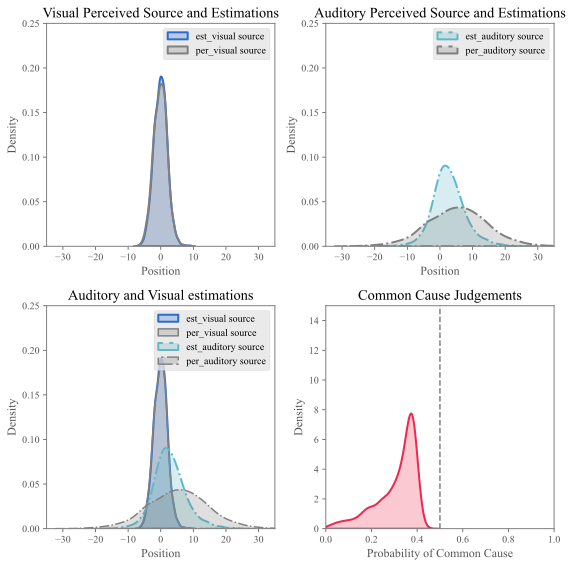

In [7]:
drawLocalization(V, A, p_common, stdV, stdA, stdPrior)

# Create Interactive Widgets

In [8]:
import ipywidgets as widgets
from ipywidgets import interact

## Fix Parameters of Vision and Audition

In [9]:
# Generate Fixed Data

def genData(s1, s2, stdx1, stdx2, n_trials=1000):

    # Generate true positions (n_trials)
    sV = np.full(n_trials, s1)
    sA = np.full(n_trials, s2)

    # Generate observations
    xV = sV + np.random.normal(0, stdx1, n_trials)
    xA = sA + np.random.normal(0, stdx2, n_trials)

    return xV, xA

fix_V = 0
fix_A = 5
fix_stdV = 2.14
fix_stdA = 9.2
fix_xV, fix_xA = genData(fix_V, fix_A, fix_stdV, fix_stdA)

In [10]:
def drawLocalization_fix(prior, stdp, n_trials=1000):

    ## Simulate Results

    # Common Cause Judgement
    common = p_xV_xA_given_common(fix_xV, fix_xA, fix_stdV, fix_stdA, stdp) * prior
    seperate = p_xV_xA_given_separate(fix_xV, fix_xA, fix_stdV, fix_stdA, stdp) * (1-prior)
    p_commonCause = common / (common + seperate)

    # Estimate positions
    est_sA = (1-p_commonCause) * est_s_sc(fix_xA, fix_stdA, stdp) + p_commonCause * est_s_cc(fix_xA, fix_xV, fix_stdA, fix_stdV, stdp)
    est_sV = (1-p_commonCause) * est_s_sc(fix_xV, fix_stdV, stdp) + p_commonCause * est_s_cc(fix_xA, fix_xV, fix_stdA, fix_stdV, stdp)

    ## Draw locations
    fig = plt.figure(figsize=(8,8))

    # Visual perceiced source and estimations
    ax1 = fig.add_subplot(2,2,1)
    ax1 = sns.kdeplot(est_sV, fill=True, color='#2C6CCE', linewidth=2, label='est_visual source')
    ax1 = sns.kdeplot(fix_xV, fill=True, color='gray', linewidth=2, label='per_visual source')
    ax1.set_facecolor("white")
    ax1.spines[:].set_color('gray')

    ax1.set_xlim((-35, 35))
    ax1.set_ylim((0, 0.25))

    ax1.legend()
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Density')
    ax1.set_title('Visual Perceived Source and Estimations')

    # Auditory source and estimations
    ax2 = fig.add_subplot(2,2,2)
    ax2 = sns.kdeplot(est_sA, fill=True, color='#61B8C9', linewidth=2, linestyle='-.', label='est_auditory source')
    ax2 = sns.kdeplot(fix_xA, fill=True, color='gray', linewidth=2, linestyle='-.', label='per_auditory source')
    ax2.set_facecolor("white")
    ax2.spines[:].set_color('gray')

    ax2.set_xlim((-35, 35))
    ax2.set_ylim((0, 0.25))

    ax2.legend()
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Density')
    ax2.set_title('Auditory Perceived Source and Estimations')

    # Auditory and Visual estimations
    ax3 = fig.add_subplot(2,2,3)
    ax3 = sns.kdeplot(est_sV, fill=True, color='#2C6CCE', linewidth=2, label='est_visual source')
    ax3 = sns.kdeplot(fix_xV, fill=True, color='gray', linewidth=1.5, label='per_visual source')
    ax3 = sns.kdeplot(est_sA, fill=True, color='#61B8C9', linewidth=2, linestyle='-.', label='est_auditory source')
    ax3 = sns.kdeplot(fix_xA, fill=True, color='gray', linewidth=1.5, linestyle='-.', label='per_auditory source')
    ax3.set_facecolor("white")
    ax3.spines[:].set_color('gray')

    ax3.set_xlim((-35, 35))
    ax3.set_ylim((0, 0.25))

    ax3.legend()
    ax3.set_xlabel('Position')
    ax3.set_ylabel('Density')
    ax3.set_title('Auditory and Visual estimations')

    # Common Cause Judgements
    ax4 = fig.add_subplot(2,2,4)
    ax4 = sns.kdeplot(p_commonCause, fill=True, linewidth=2, color='#EE284D')
    ax4.axvline(0.5, color='gray', linestyle='--')
    ax4.set_facecolor("white")
    ax4.spines[:].set_color('gray')

    ax4.set_xlim((0, 1))
    ax4.set_ylim((0, 15))

    ax4.set_xlabel('Probability of Common Cause')
    ax4.set_ylabel('Density')
    ax4.set_title('Common Cause Judgements')

    plt.tight_layout()

In [11]:
interact(drawLocalization_fix,prior=widgets.FloatSlider(min=0, max=0.99, step=0.01, value=0.20),
                              stdp=widgets.IntSlider(min=0, max=20, step=1, value=12))

interactive(children=(FloatSlider(value=0.2, description='prior', max=0.99, step=0.01), IntSlider(value=12, de…

<function __main__.drawLocalization_fix(prior, stdp, n_trials=1000)>

## Free All Parameters

In [12]:
interact(drawLocalization, s1=widgets.IntSlider(min=-10, max=10, step=1, value=0),
                           s2=widgets.IntSlider(min=-10, max=10, step=1, value=5),
                           prior=widgets.FloatSlider(min=0, max=0.99, step=0.01, value=0.20),
                           stdx1=widgets.IntSlider(min=1, max=20, step=1, value=2),
                           stdx2=widgets.IntSlider(min=1, max=20, step=1, value=10),
                           stdp=widgets.IntSlider(min=1, max=20, step=1, value=12),
                           )

interactive(children=(IntSlider(value=0, description='s1', max=10, min=-10), IntSlider(value=5, description='s…

<function __main__.drawLocalization(s1, s2, prior, stdx1, stdx2, stdp, n_trials=1000)>